<a href="https://colab.research.google.com/github/Manish22332/my_projects/blob/main/Stocks_Time_Series_Forcasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

First mounting the dataset from gdrive

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Import necessary libraries

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import os
import datetime
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

Read the excel file and normalize the data

In [3]:
df = pd.read_excel('/content/gdrive/My Drive/colab_dataset/dataset/nestle_time_series.xlsx')
df.index = df['Date']
df.drop('Date', axis=1, inplace=True)
# normalization
df_mean = df.mean()
df_std = df.std()
df = (df - df_mean)/df_std

Split the train, val and test set

In [21]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

Plot the data to see the distribution in a violin plot

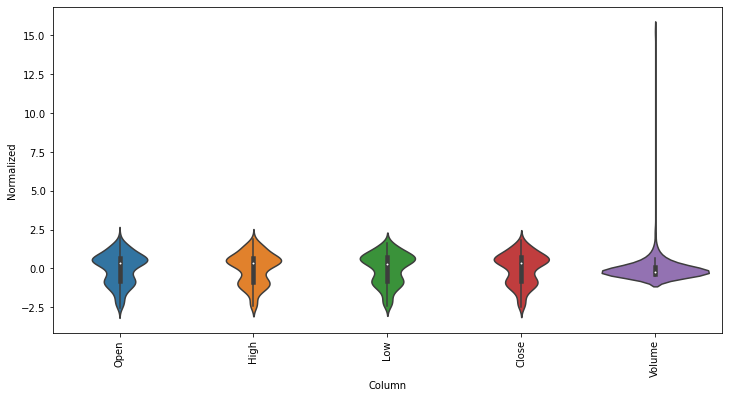

In [22]:
df_std = df.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

Window selection of the input features of train, val and test set along with labels

In [23]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

Selecting a sample window 

In [24]:
# Window selection 1
W1 = WindowGenerator(input_width=14, label_width=1, shift=14, label_columns=['Close'])    
# Window selection 2
W2 = WindowGenerator(input_width=6, label_width=1, shift=1, label_columns=['Close'])    

Convert the input window into input and label window

In [25]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window  

A sample selection of the window

In [26]:
# Stack three slices, the length of the total window:
example_window = tf.stack([np.array(train_df[:W2.total_window_size]),
                           np.array(train_df[50:50+W2.total_window_size]),
                           np.array(train_df[100:100+W2.total_window_size])])


example_inputs, example_labels = W2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'labels shape: {example_labels.shape}')  

All shapes are: (batch, time, features)
Window shape: (3, 7, 5)
Inputs shape: (3, 6, 5)
labels shape: (3, 1, 1)


Visualize the window selection

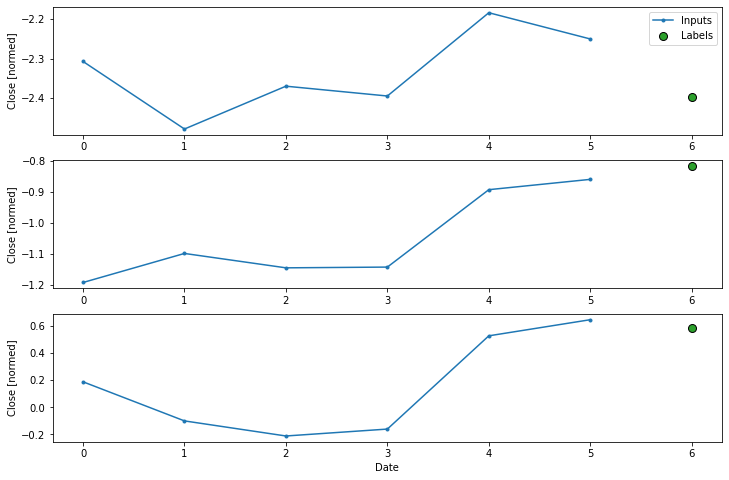

In [27]:
W2.example = example_inputs, example_labels

def plot(self, model=None, plot_col='Close', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(3, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Date')

WindowGenerator.plot = plot
W2.plot()

We can change the plotted column by changing the label column name to a different column

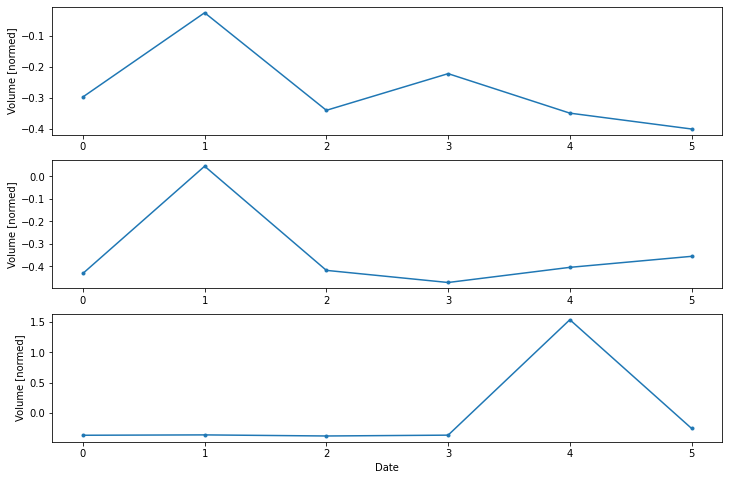

In [28]:
W2.plot(plot_col='Volume')

Convert the data to tf.data.Dataset so that we can iterate over the data easily

In [29]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset    

In [30]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example    

To get the properties of the dataset, use Dataset.element_spec

In [31]:
W2.train.element_spec

(TensorSpec(shape=(None, 6, 5), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

Iterating over training data to see the batches

In [32]:
for example_inputs, example_labels in W2.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 6, 5)
Labels shape (batch, time, features): (32, 1, 1)


Benchmarking different models with different window size. 

In [33]:
single_step_window = WindowGenerator(input_width=1, label_width=1, shift=1, label_columns=['Close'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['Close']

In [34]:
for example_inputs, example_labels in single_step_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 5)
Labels shape (batch, time, features): (32, 1, 1)


First going through the baseline model with single window

In [35]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

In [36]:
baseline = Baseline(label_index=column_indices['Close'])

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

2/2 [==============================] - 0s 1ms/step - loss: 0.0220 - mean_absolute_error: 0.1107


Creating a wider window as it is easier to interpret

In [37]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['Close'])

wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['Close']

In [38]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 24, 5)
Output shape: (32, 24, 1)


The plot of baseline model is only the labels shifted 1 step to the right

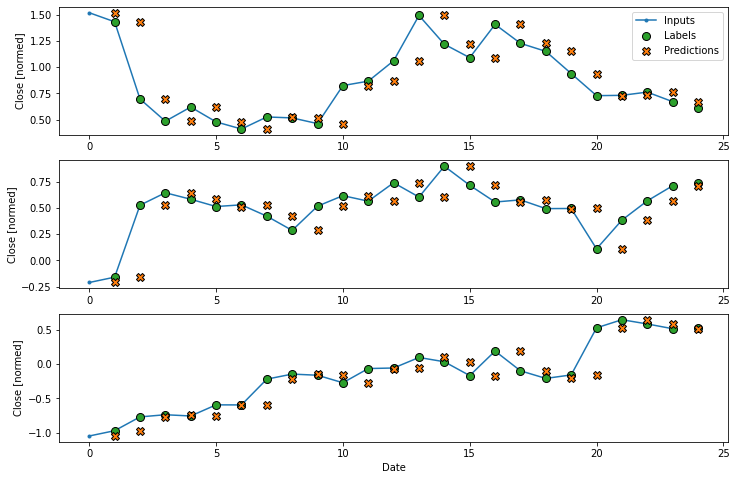

In [39]:
wide_window.plot(baseline)

Now let's build a linear model

In [40]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

In [41]:
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)

Input shape: (32, 1, 5)
Output shape: (32, 1, 1)


Packaging the training of the model in order to use the function for other models

In [42]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

Training the linear model

In [43]:
history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
7/7 [==============================] - 0s 18ms/step - loss: 2.4986 - mean_absolute_error: 1.3449 - val_loss: 1.3640 - val_mean_absolute_error: 1.0968
Epoch 2/20
7/7 [==============================] - 0s 8ms/step - loss: 2.4066 - mean_absolute_error: 1.3187 - val_loss: 1.3243 - val_mean_absolute_error: 1.0811
Epoch 3/20
7/7 [==============================] - 0s 9ms/step - loss: 2.3144 - mean_absolute_error: 1.2926 - val_loss: 1.2839 - val_mean_absolute_error: 1.0648
Epoch 4/20
7/7 [==============================] - 0s 8ms/step - loss: 2.2279 - mean_absolute_error: 1.2671 - val_loss: 1.2440 - val_mean_absolute_error: 1.0483
Epoch 5/20
7/7 [==============================] - 0s 8ms/step - loss: 2.1397 - mean_absolute_error: 1.2412 - val_loss: 1.2048 - val_mean_absolute_error: 1.0319
Epoch 6/20
7/7 [==============================] - 0s 8ms/step - loss: 2.0556 - mean_absolute_error: 1.2160 - val_loss: 1.1658 - val_mean_absolute_error: 1.0153
Epoch 7/20
7/7 [=======================

Here's the plot of predictions of linear model

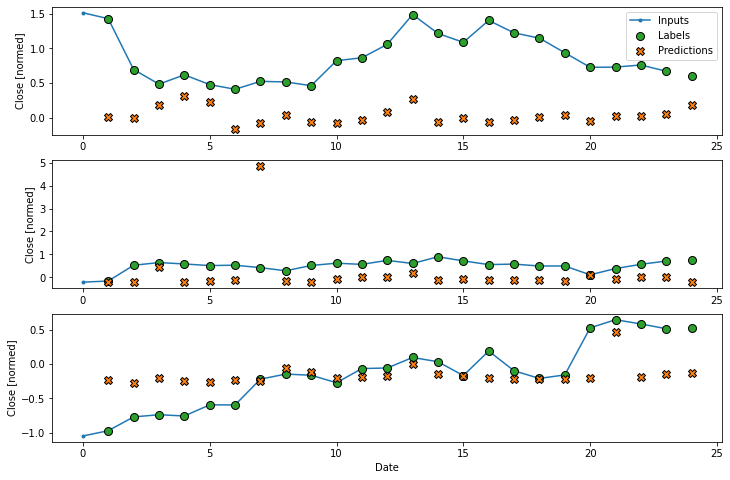

In [44]:
wide_window.plot(linear)

Now let's see the weightage of each feature which the model has chosen

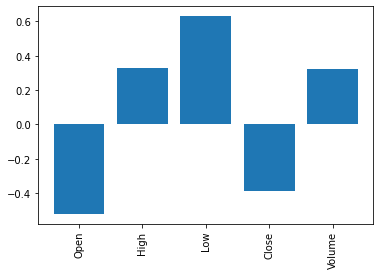

In [45]:
plt.bar(x = range(len(train_df.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)

Building a dense model by stacking multiple dense layers

In [46]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
7/7 [==============================] - 0s 23ms/step - loss: 1.0247 - mean_absolute_error: 0.8689 - val_loss: 0.2625 - val_mean_absolute_error: 0.4687
Epoch 2/20
7/7 [==============================] - 0s 8ms/step - loss: 0.3893 - mean_absolute_error: 0.5091 - val_loss: 0.0528 - val_mean_absolute_error: 0.1884
Epoch 3/20
7/7 [==============================] - 0s 9ms/step - loss: 0.1394 - mean_absolute_error: 0.2713 - val_loss: 0.0287 - val_mean_absolute_error: 0.1365
Epoch 4/20
7/7 [==============================] - 0s 8ms/step - loss: 0.1062 - mean_absolute_error: 0.2374 - val_loss: 0.0384 - val_mean_absolute_error: 0.1612
Epoch 5/20
7/7 [==============================] - 0s 8ms/step - loss: 0.1133 - mean_absolute_error: 0.2556 - val_loss: 0.0241 - val_mean_absolute_error: 0.1204
Epoch 6/20
7/7 [==============================] - 0s 9ms/step - loss: 0.0972 - mean_absolute_error: 0.2230 - val_loss: 0.0240 - val_mean_absolute_error: 0.1170
Epoch 7/20
7/7 [=======================

Implementing multi step dense model

In [47]:
CONV_WIDTH = 3
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['Close'])

conv_window

Total window size: 4
Input indices: [0 1 2]
Label indices: [3]
Label column name(s): ['Close']

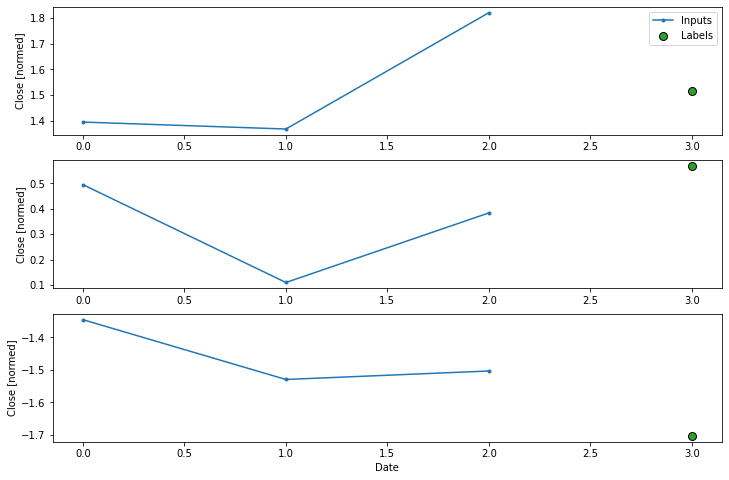

In [48]:
conv_window.plot()

A multi step model can be implemented by addding a flatten layer as the first layer to the dense model

In [49]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

In [50]:
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', multi_step_dense(conv_window.example[0]).shape)

Input shape: (32, 3, 5)
Output shape: (32, 1, 1)


In [51]:
history = compile_and_fit(multi_step_dense, conv_window)

IPython.display.clear_output()
val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0)

2/2 [==============================] - 0s 2ms/step - loss: 0.0447 - mean_absolute_error: 0.1685


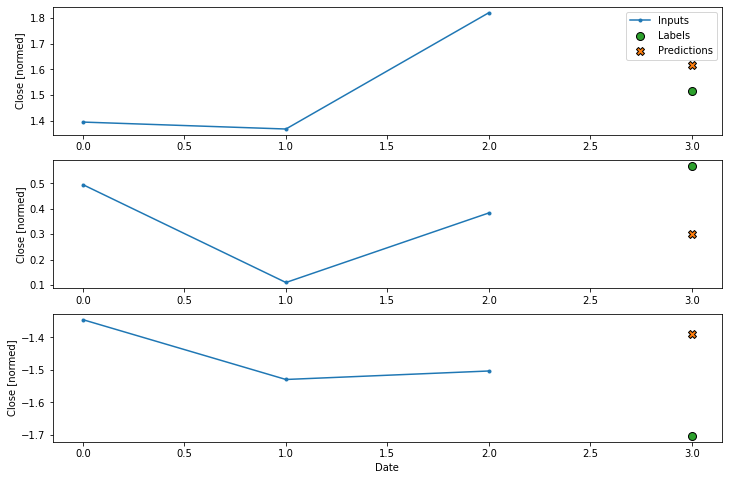

In [52]:
conv_window.plot(multi_step_dense)

The main down-side of this approach is that the resulting model can only be executed on input windows of exactly this shape.

In [53]:
print('Input shape:', wide_window.example[0].shape)
try:
  print('Output shape:', multi_step_dense(wide_window.example[0]).shape)
except Exception as e:
  print(f'\n{type(e).__name__}:{e}')

Input shape: (32, 24, 5)

InvalidArgumentError:Matrix size-incompatible: In[0]: [32,120], In[1]: [15,32] [Op:MatMul]


Building CNN model

In [54]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

In [55]:
print("Conv model on `conv_window`")
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape)

Conv model on `conv_window`
Input shape: (32, 3, 5)
Output shape: (32, 1, 1)


Training CNN

In [56]:
history = compile_and_fit(conv_model, conv_window)

IPython.display.clear_output()
val_performance['Conv'] = conv_model.evaluate(conv_window.val)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)

2/2 [==============================] - 0s 3ms/step - loss: 0.0335 - mean_absolute_error: 0.1413


The CNN model works of input of any shape

In [57]:
print("Wide window")
print('Input shape:', wide_window.example[0].shape)
print('Labels shape:', wide_window.example[1].shape)
print('Output shape:', conv_model(wide_window.example[0]).shape)

Wide window
Input shape: (32, 24, 5)
Labels shape: (32, 24, 1)
Output shape: (32, 22, 1)


Changing the input width so that it label and prediction width matches

In [60]:
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['Close'])

wide_conv_window

Total window size: 27
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]
Label indices: [ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26]
Label column name(s): ['Close']

In [61]:
print("Wide conv window")
print('Input shape:', wide_conv_window.example[0].shape)
print('Labels shape:', wide_conv_window.example[1].shape)
print('Output shape:', conv_model(wide_conv_window.example[0]).shape)

Wide conv window
Input shape: (32, 26, 5)
Labels shape: (32, 24, 1)
Output shape: (32, 24, 1)


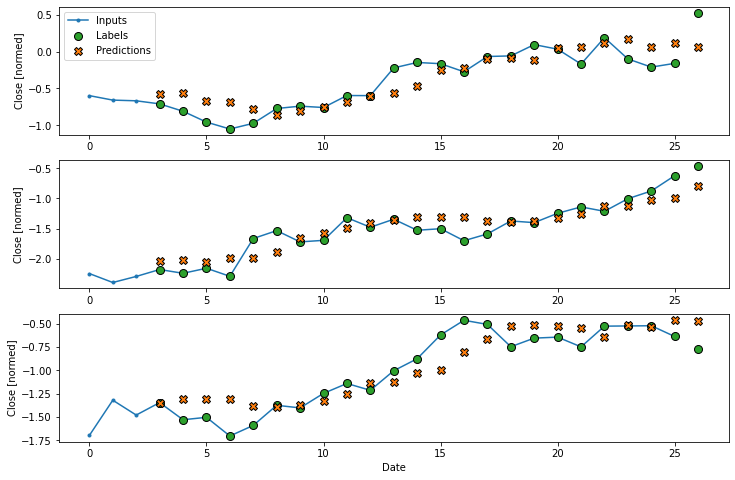

In [62]:
wide_conv_window.plot(conv_model)

Now let's build an LSTM model which is very well suited for time series forcasting. Keeping return_sequence as True will make this model for multi step input

In [63]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [64]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

Input shape: (32, 24, 5)
Output shape: (32, 24, 1)


In [65]:
history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

2/2 [==============================] - 0s 3ms/step - loss: 0.0495 - mean_absolute_error: 0.1644


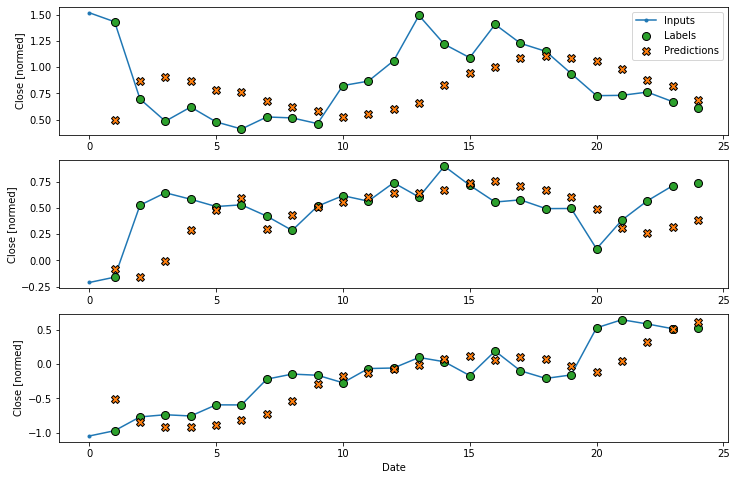

In [66]:
wide_window.plot(lstm_model)

Comparing the performace of all the models

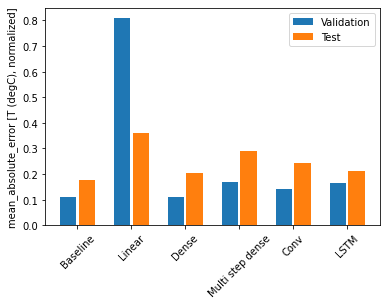

In [67]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [T (degC), normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

In [68]:
for name, value in performance.items():
  print(f'{name:12s}: {value[1]:0.4f}')

Baseline    : 0.1760
Linear      : 0.3607
Dense       : 0.2028
Multi step dense: 0.2914
Conv        : 0.2448
LSTM        : 0.2118
